# Developing Well Calibrated Illness Severity Scores
## APACHE IV Analysis
### C.V. Cosgriff, MIT Critical Data

In this notebook we will examine how the APACHE IV score performs in our cohort.
    
## 0 - Environement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

from xgboost import XGBClassifier, plot_importance

import pickle

# "Tableau 20" colors as RGB for plotting
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1 - Models, Data, and Helper Functions

We need to load both the training and testing sets in order to determine the entire cohort APACHE performance.

In [2]:
test_X = pd.read_csv('../extraction/data/test_X.csv').set_index('patientunitstayid').values
test_y = pd.read_csv('../extraction/data/test_y.csv').values.ravel()
test_apache = pd.read_csv('../extraction/data/test_apache.csv').values.ravel()

test_X_HR = test_X[(test_apache >= 0.10), :]
test_y_HR = test_y[test_apache >= 0.10]
test_apache_HR = test_apache[test_apache >= 0.10]

We'll introduce helper functions for generating confidence intervals.

In [3]:
def auc_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1 - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_auc = []

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        auc = roc_auc_score(y_true[indices], f_hat[indices])
        bootstrapped_auc.append(auc)

    sorted_scores = np.array(bootstrapped_auc)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio_ci(f_hat, y_true, n_bootstraps=2000, ci_level=0.95):
    li = (1. - ci_level)/2
    ui = 1. - li

    rng = np.random.RandomState(seed=42)
    bootstrapped_opr = []
    
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(f_hat), len(f_hat))
        opr = y_true[indices].mean() / f_hat[indices].mean()
        bootstrapped_opr.append(opr)

    sorted_scores = np.array(bootstrapped_opr)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(li * len(sorted_scores))]
    confidence_upper = sorted_scores[int(ui * len(sorted_scores))]

    return confidence_lower, confidence_upper

def op_ratio(model, X, y):
    f_hat = model.predict_proba(X)
    observed = y.mean()
    predicted = f_hat[:, 1].mean()
    return (observed / predicted, *op_ratio_ci(f_hat[:, 1], y))

## 2 - APACHE IV Evaluation

We begin by evaluating APACHE IV discriminative ability in the entire cohort by generating an ROC curve.

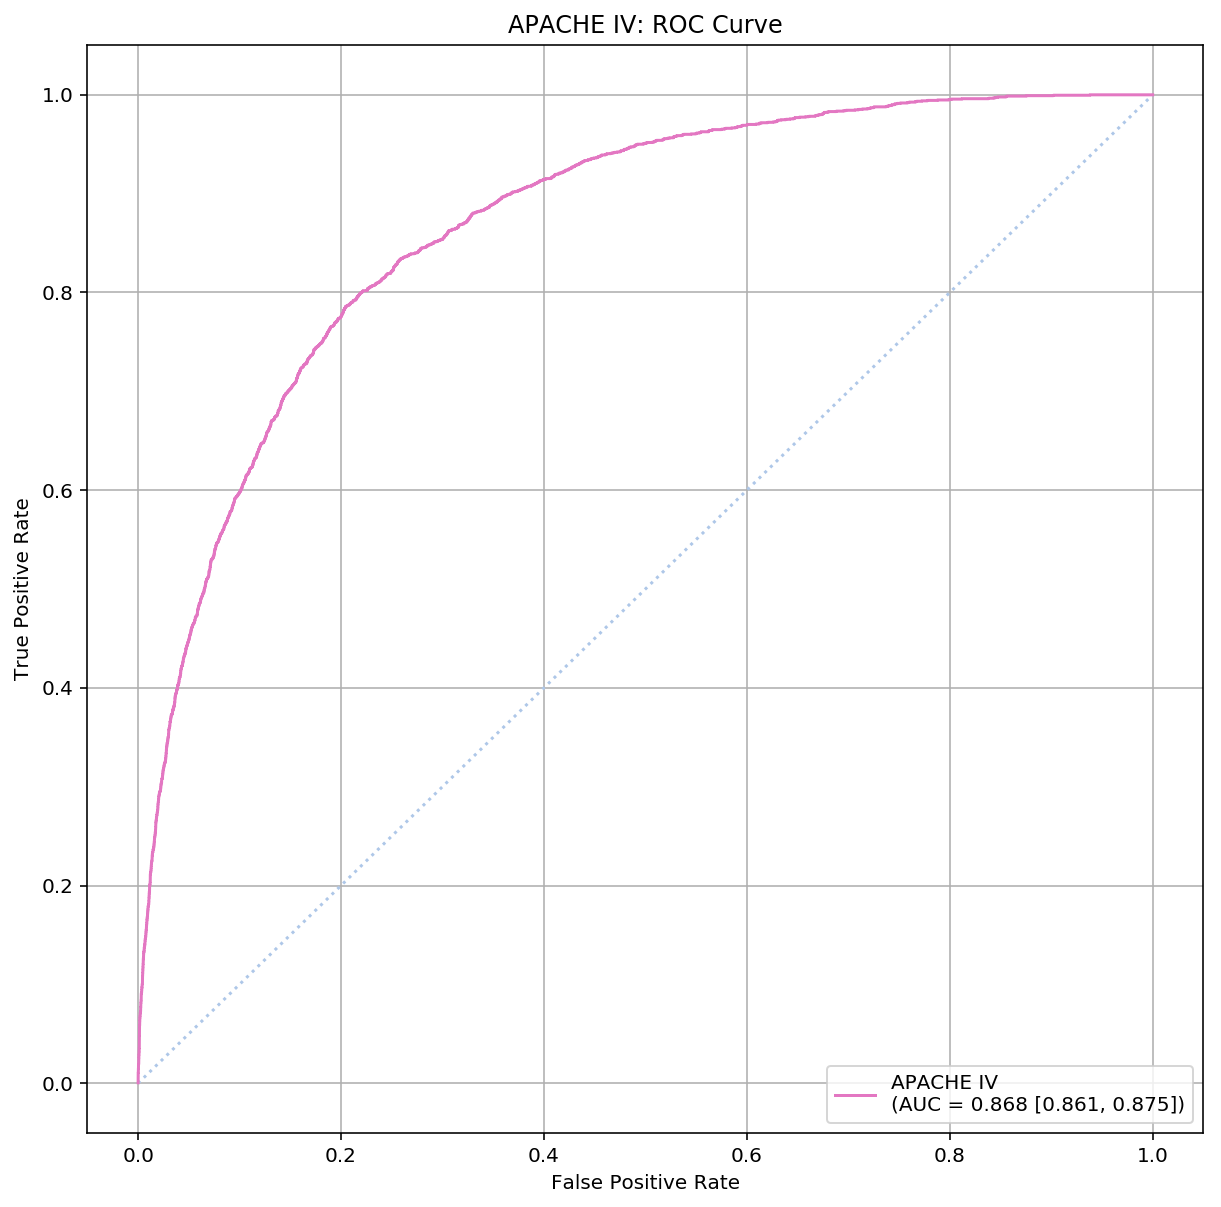

In [4]:
f_hat_apache = test_apache
y_true = test_y
roc_apache = roc_curve(y_true, f_hat_apache)
auc_apache = roc_auc_score(y_true, f_hat_apache)

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
plt.plot(roc_apache[0], roc_apache[1], color=tableau20[12], 
         label='APACHE IV\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_apache, *auc_ci(f_hat_apache, y_true)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('APACHE IV: ROC Curve')
plt.legend(loc="lower right")

plt.savefig('./figures/roc-apache_full.svg', bbox_inches='tight')
plt.grid()
plt.show()

We then examine its calibration via a reliability curve.

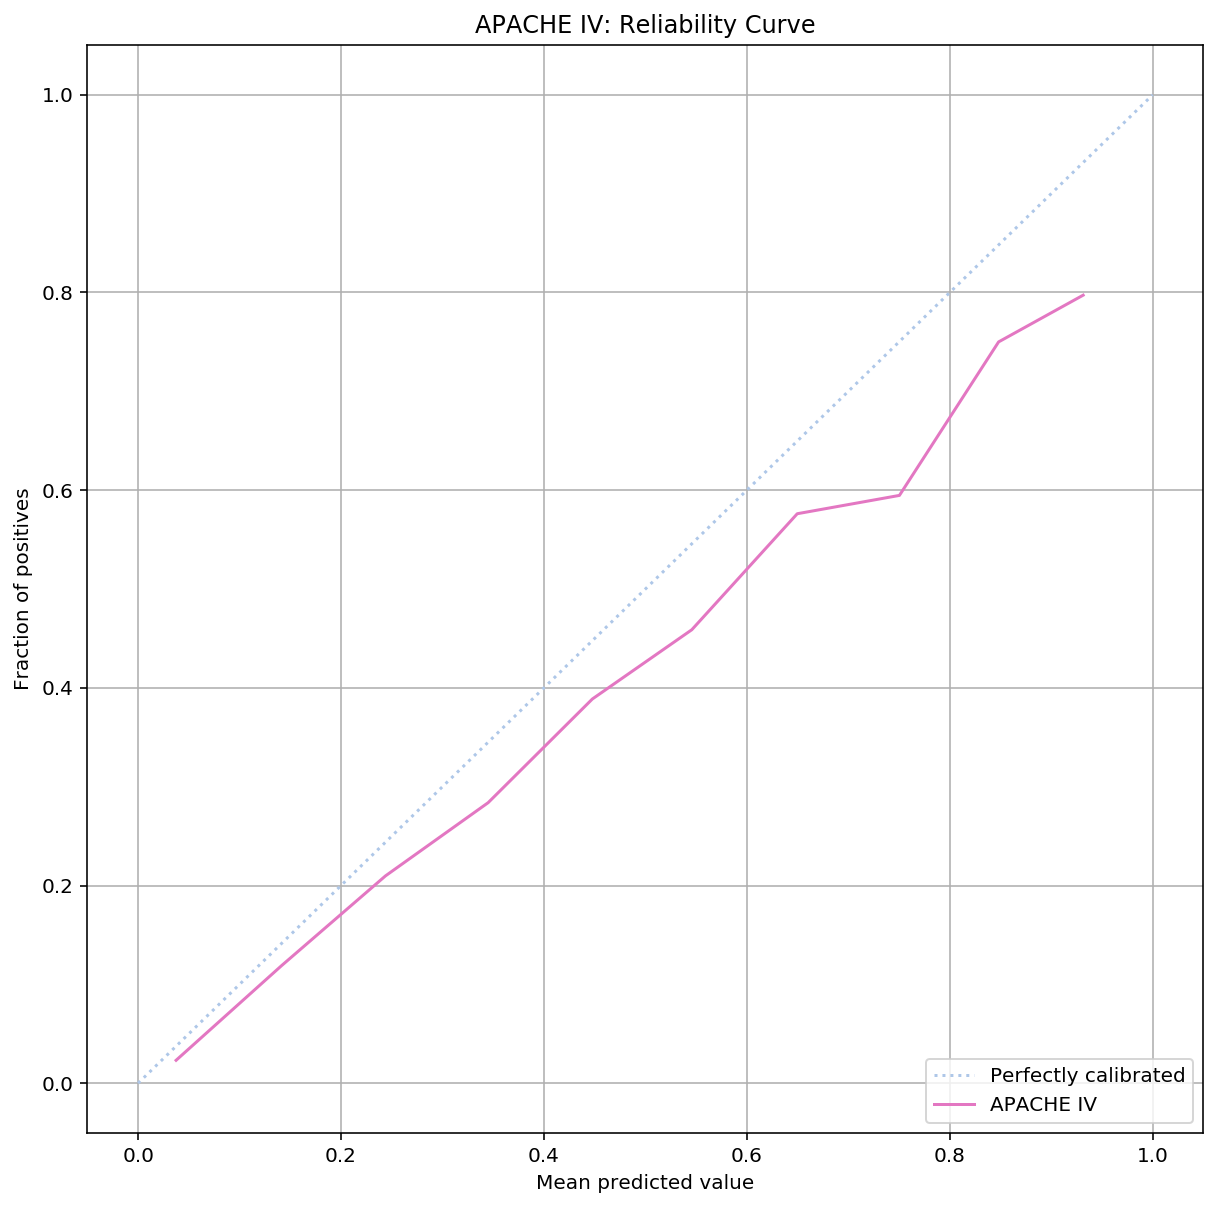

In [5]:
fraction_of_positives_apache, mean_predicted_value_apache = calibration_curve(y_true, f_hat_apache, n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[1])

ax1.plot(mean_predicted_value_apache, fraction_of_positives_apache, color=tableau20[12], 
         label='APACHE IV')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('APACHE IV: Reliability Curve')
ax1.set_xlabel("Mean predicted value")

plt.grid()
plt.savefig('./figures/calib-apache_full.svg', bbox_inches='tight')
plt.show()

In [6]:
print('APACHE IVa OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(y_true.mean()/f_hat_apache.mean(), *op_ratio_ci(f_hat_apache, y_true)))

APACHE IVa OPR: 0.802 [0.775, 0.829]


Finally, we re-perform these calculations in the HR cohort.

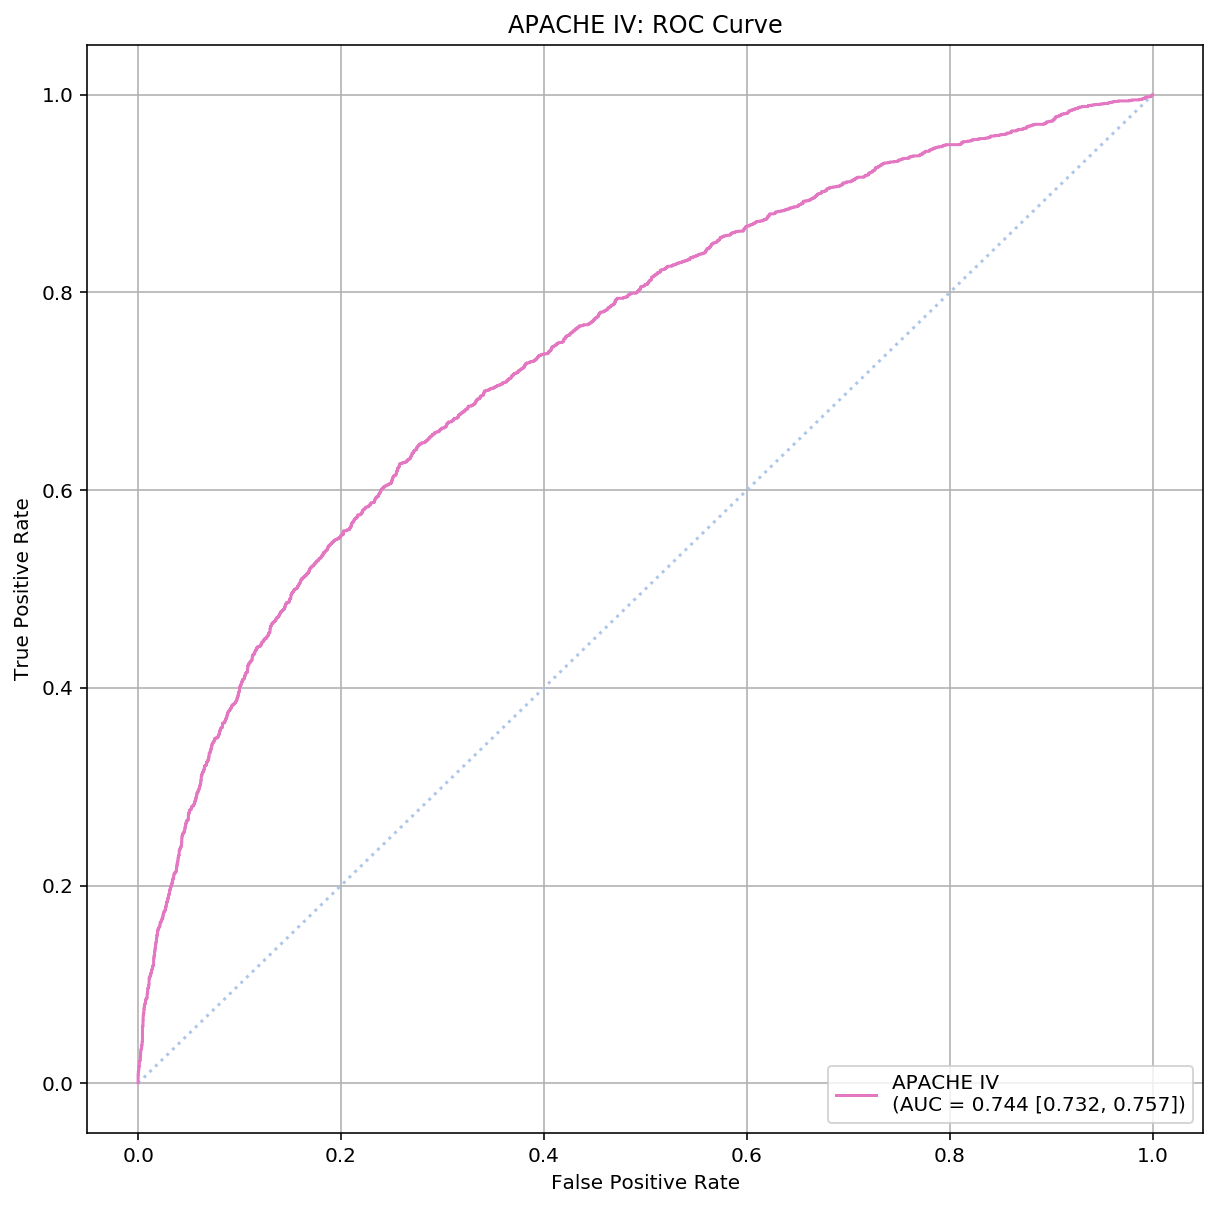

In [7]:
f_hat_apache = test_apache_HR
y_true = test_y_HR
roc_apache = roc_curve(y_true, f_hat_apache)
auc_apache = roc_auc_score(y_true, f_hat_apache)

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k:', color=tableau20[1])
plt.plot(roc_apache[0], roc_apache[1], color=tableau20[12], 
         label='APACHE IV\n(AUC = {0:.3f} [{1:.3f}, {2:.3f}])'.format(auc_apache, *auc_ci(f_hat_apache, y_true)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('APACHE IV: ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.savefig('./figures/roc-apache_HR.svg', bbox_inches='tight')
plt.show()

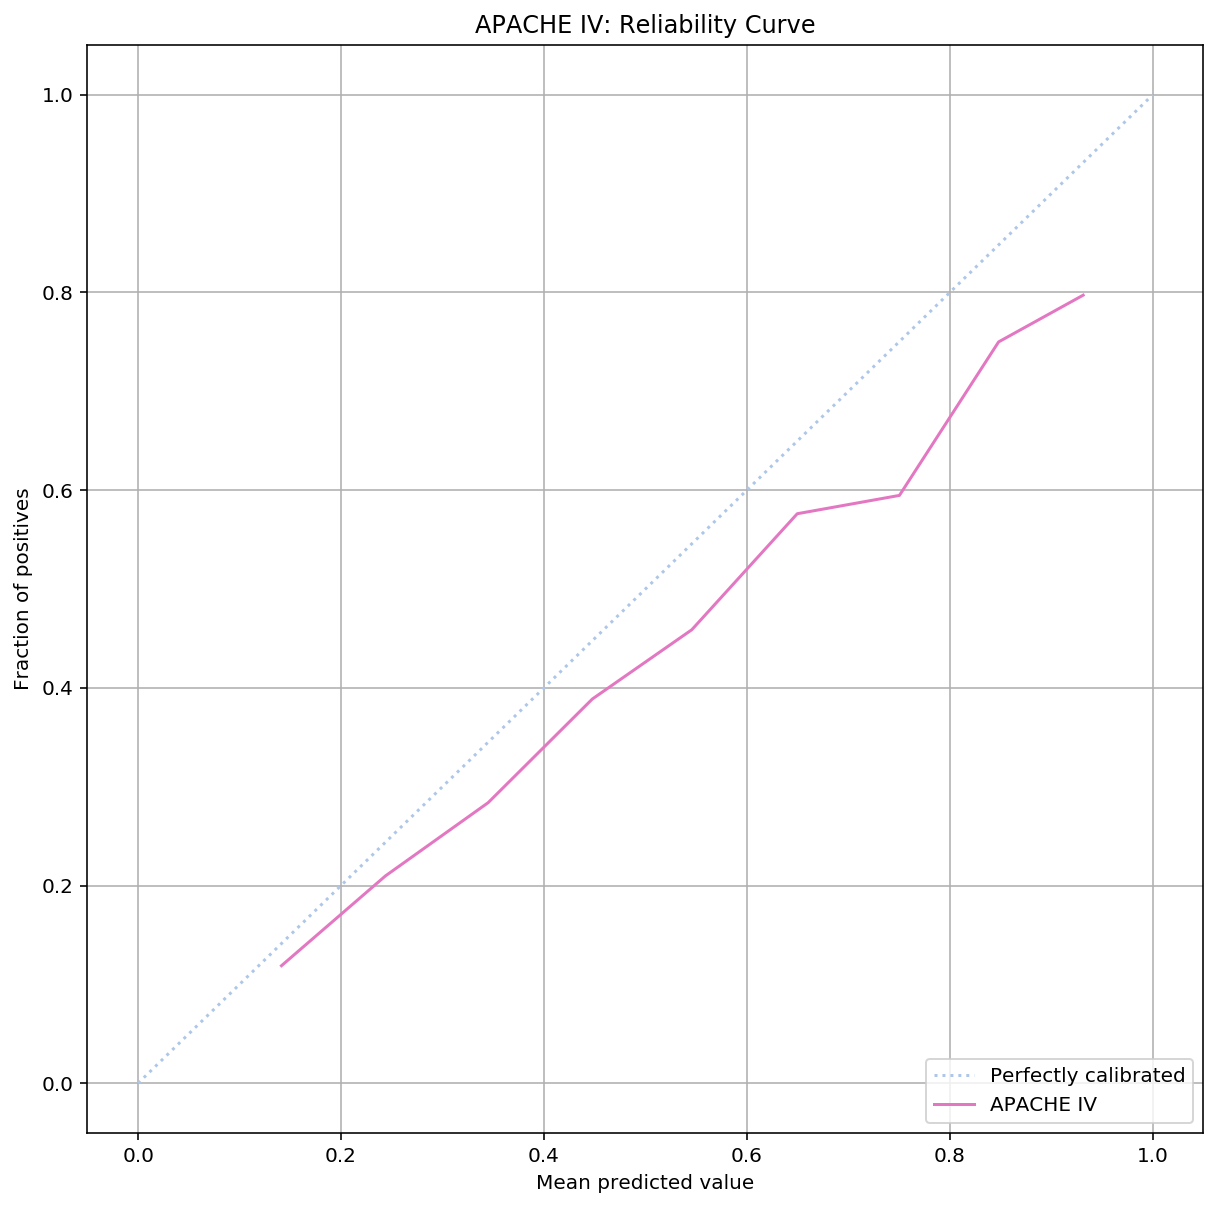

In [8]:
fraction_of_positives_apache, mean_predicted_value_apache = calibration_curve(y_true, f_hat_apache, n_bins=10)

plt.figure(figsize=(10, 10))
ax1 = plt.axes()
ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated', color=tableau20[1])

ax1.plot(mean_predicted_value_apache, fraction_of_positives_apache, color=tableau20[12], 
         label='APACHE IV')

ax1.set_ylabel("Fraction of positives")
ax1.legend(loc="lower right")
ax1.set_title('APACHE IV: Reliability Curve')
ax1.set_xlabel("Mean predicted value")

plt.grid()
plt.savefig('./figures/calib-apache_HR.svg', bbox_inches='tight')
plt.show()

In [9]:
print('APACHE IVa OPR: {0:.3f} [{1:.3f}, {2:.3f}]'.format(y_true.mean()/f_hat_apache.mean(), *op_ratio_ci(f_hat_apache, y_true)))

APACHE IVa OPR: 0.848 [0.819, 0.878]


We now turn to the development of new models to improve mortality forecasting in HR patients.